In [4]:
import pymc3 as pm 
import numpy as np 
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os 

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 17}

plt.rc('font', **font)


/Applications/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Applications/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Sum of Squares Likelihood

In [5]:
import theano 
import pymc3 as pm
from scipy import stats
from theano import shared, tensor as tt
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False
    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)
def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.

    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5
    # cast tau and sigma to float in a way that works for both np.arrays
    # and pure python
    tau = 1. * tau
    sigma = 1. * sigma
    return floatX(tau), floatX(sigma)
class Sum_of_Squares(pm.distributions.Continuous):
    
    def __init__(self, mu=0, sigma=None, tau=None, sd=None, **kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)
        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau
        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')
        super().__init__(**kwargs)
        
    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)
    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        
        logp = - tt.sqr(value - mu)/(2.0 * sigma *sigma)
        return logp.sum()

In [6]:
cwd = os.chdir("/Users/danbarfod/Downloads")
df6 = pd.read_csv("Kula_Biotite_3_data.csv",
                  engine = 'python')
df6.dropna(axis =0, how = 'all')

temp1 = df6['Temp'].values
time1 = df6['Time'].values
a391 = df6['39Ar'].values
a401 = df6['40Ar'].values
age1 = df6['Age'].values
age1_err = df6['Age_Err'].values

In [7]:
# Shared variable for modelling 
from theano import shared, tensor as tt
data = age1
err = age1_err

age_err = shared(err*2)

In [8]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

In [9]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [10]:
def frel_data(x): 
    y = np.cumsum(x) 
    dd = y/y.max()
    return dd

In [12]:
x = frel_data(a391)

# The Age Spectra

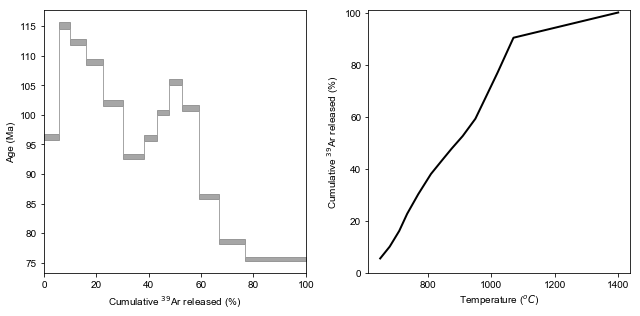

In [9]:
y = np.insert(x, 0, 0)
age_plot = np.insert(data, 0, data[0])
age_plot_err = np.insert(err, 0, err[0])


fig, ax = plt.subplots(1,2, figsize = (9, 4.5))

ax[0].fill_between(y, age_plot - age_plot_err, age_plot + age_plot_err, 
                  step = 'pre', 
                  color = 'grey', alpha = 0.7, 
                  edgecolor = 'k')
ax[0].set_xlim(y.min(), y.max())

ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')

ax[1].plot(temp1,x, lw = 2, 
          color= 'k')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperature ($^{o}C$)')
ax[1].set_ylim(0, 101)
plt.tight_layout()

In [10]:
data_f = x/100
tempk = temp1 + 273.15
t_obs = time1 * 60
N = data.shape[0]
R = 8.314e-3

age_error_for_model = shared(err*2)

In [11]:
Q = pm.Model()

with Q: 
    """
    Mixing Fraction
    """ 
    phi = pm.Dirichlet('phi', 
                      a = np.array([0.25,0.75]), 
                      shape = 2, 
                       testval = (0.25, 0.75))
    """
    Assign each mixing fraction to
    a parameter
    """
    w1 = phi[0]
    w2 = phi[1]
    
    """
    Bounding contraint for the mixing fraction
    """ 
    w1_potential = pm.Potential('p1_con', 
                               tt.switch(w1 < 0.2, 
                                        -np.inf, 0) + 
                               tt.switch(w1 > 0.3, 
                                        -np.inf, 0))
    
    """
    Activation energy and Frequency Factor
    """
    ea1 = pm.Normal('ea1', mu = 196,
                    sd = 16)
    ea2 = pm.Normal('ea2', mu = 196,
                    sd = 16)

    lnd01 = pm.Normal('lnd01', mu = -2.6,
                       sd = 1.9)
    
    lnd02 = pm.Normal('lnd02', mu = -2.6,
                       sd = 1.9)
    
    d01 = pm.Deterministic('d01', np.exp(lnd01))
    
    d02 = pm.Deterministic('d02', np.exp(lnd02))
    
    """
    Diffusion lengthscale
    ~ Grain radii
    """
    a1 = pm.Uniform('a1', lower = 0.0177/2, 
                   upper= 0.025/2)
    
    a2 = pm.Uniform('a2', lower = 0.0177/2, 
                   upper= 0.025/2)

In [12]:
with Q: 
    """
    Age Prior for each component
    between 0 - 4.6 Ga
    """
    
    age1 = pm.Uniform('age1', lower = 0.0, upper = 4600, 
                     testval = 200)
    
    age2 = pm.Uniform('age2', lower = 0.0, upper = 4600, 
                     testval = 100)
    """
    Constraint to prevent ages being equal
    """
    
    age_cons = pm.Potential('age_con', 
                           tt.switch(age1 - age2 < 0, 
                                    -np.inf, 0))

In [13]:
with Q: 
    """
    Age Spectra Model
    """
    
    X = Increment(ea1, d01, a1, tempk, t_obs)
    Y = Increment(ea2, d02, a2, tempk, t_obs)

    
    mu2 = ((w1*X)/(w1*X + w2*Y))*age1 +\
    ((w2*Y)/(w1*X + w2*Y))*age2   


In [14]:
with Q: 
    """
    Cumulative Release Model
    """

    A = fracrelx(ea1, d01, a1, tempk, t_obs)
    B = fracrelx(ea2, d02, a2, tempk, t_obs)
    
    mu1 = w1*A + w2*B

    """
    Monotonicity constraint
    probably not needed but seems to 
    improve sampling
    """
    for i in range(len(tempk) -1): 
        F_con1 = pm.Potential(f'F_con1{i}', 
                             tt.switch(A[i + 1] - A[i] <0, 
                                      -np.inf, 0) + 
                             tt.switch(B[i +1] - B[i] < 0, 
                                      -np.inf, 0))

    for i in range(len(tempk) -1): 
        F_con2 = pm.Potential(f'F_con2{i}', 
                             tt.switch(mu1[i + 1] - mu1[i] <0, 
                                      -np.inf, 0))
        
    # Constraint to the fractional release model 
    frac_rel_cons = pm.Potential('frac_rel_cons', 
                                tt.switch(mu1 >1, -np.inf, 0))
######################################################################    

    """
    Cumulative release model error
    """
    f_err1 = pm.HalfNormal('f_err1', 
                           sd = 0.1, 
                          shape = N)

In [16]:
with Q: 
    """
    Age model error
    """
    age_model_error = pm.HalfNormal('age_model_error', 
                                   sd = 5, 
                                   shape = N)

In [17]:
with Q: 
    """
    Cumulative Release Likelihood
    """
    L1 = pm.Normal('L1', mu = mu1, 
                   sd = f_err1, 
                   observed = data_f)
    
    """
    Age Spectra Likelihood
    """
    L2 = Sum_of_Squares('L2', mu2, age_model_error, 
                        observed = data)


# Check Test Value for logp

In [18]:
Q.check_test_point()

phi_stickbreaking__        -2.05
ea1                        -3.69
ea2                        -3.69
lnd01                      -1.56
lnd02                      -1.56
a1_interval__              -1.39
a2_interval__              -1.39
age1_interval__            -3.18
age2_interval__            -3.85
f_err1_log__              -10.78
age_model_error_log__     -10.78
L1                       -118.05
L2                      -2713.54
Name: Log-probability of test_point, dtype: float64

In [19]:
SAMPLES = 100000
BURN = 200000
with Q: 
    step1 = pm.Metropolis([a1, a2, 
                     age1, age2, 
                          ea1, ea2, 
                     d01, d02, f_err1, 
                          phi, age_model_error])
    

    

    trace = pm.sample(SAMPLES, 
                      tune = BURN, 
                     step = [step1], 
                     cores = 2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [age_model_error]
>Metropolis: [phi]
>Metropolis: [f_err1]
>Metropolis: [lnd02]
>Metropolis: [lnd01]
>Metropolis: [ea2]
>Metropolis: [ea1]
>Metropolis: [age2]
>Metropolis: [age1]
>Metropolis: [a2]
>Metropolis: [a1]
Sampling 2 chains: 100%|██████████| 600000/600000 [24:23<00:00, 410.06draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


# Get Ages

In [20]:
print(trace['age1'][-SAMPLES:].mean(axis =0))
print(trace['age2'][-SAMPLES:].mean(axis =0))

print(trace['age1'][-SAMPLES:].std(axis =0))
print(trace['age2'][-SAMPLES:].std(axis =0))

152.5937786816386
75.53677820910016
12.878732126885739
1.4286409107389881


# Post Posterior Predictions


In [21]:
with Q: 
    ppc = pm.sample_ppc(trace, 10000)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 10000/10000 [01:23<00:00, 119.36it/s]


# Posterior Predictive model and 95% Credible Intervals

In [22]:
x1 = ppc['L1'].mean(axis = 0)
x2 = ppc['L2'].mean(axis = 0)

# 95% Credible model intervals 
low_age, high_age = np.percentile(ppc['L2'],
                                  [2.5, 97.5], 
                                  axis=0)
low_f, high_f = np.percentile(ppc['L1'], 
                             [20, 80], 
                             axis = 0)

In [23]:
low_age_plot = np.insert(low_age, 0, low_age[0])
high_age_plot = np.insert(high_age, 0, high_age[0])

In [16]:
"""
Plotting Parameters
"""

x2_plot = np.insert(x2, 0, x2[0])
low_age_plot = np.insert(low_age, 0, low_age[0])
high_age_plot = np.insert(high_age, 0, high_age[0])



x1_plot = np.insert(y, 0, 0)
age_plot = np.insert(data, 0, data[0])
age_plot_err = np.insert(err, 0,err[0])

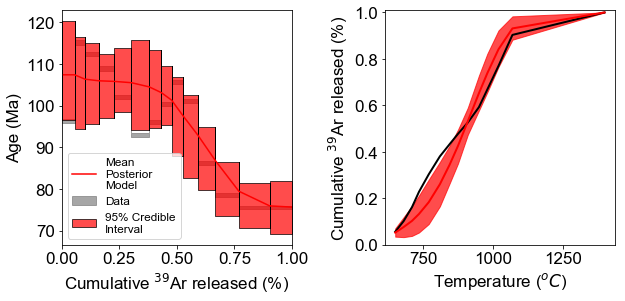

In [15]:
y = np.insert(x, 0, 0)
age_plot = np.insert(data, 0, data[0])
age_plot_err = np.insert(err, 0, err[0])


fig, ax = plt.subplots(1,2, figsize = (9, 4.5))
# Age
ax[0].fill_between(y, age_plot - age_plot_err, age_plot + age_plot_err, 
                  step = 'pre', 
                  color = 'grey', alpha = 0.7, 
                  edgecolor = 'k', 
                  label = 'Data')
ax[0].set_xlim(y.min(), y.max())


ax[0].plot(x1_plot, x2_plot, 'r-',
          label= 'Mean\nPosterior\nModel')
ax[0].fill_between(x1_plot, low_age_plot, 
                   high_age_plot,
                  step = 'pre', 
                  facecolor = 'r', alpha = 0.7, 
                  edgecolor = 'k', 
                  label = '95% Credible\nInterval')

for i in range(len(x1_plot)):
    ax[0].vlines(x1_plot, low_age_plot, 
                   high_age_plot,
                 color = 'k', 
                lw = 0.8)
ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')


# Cumulative Release

ax[1].plot(temp1,x, lw = 2, 
          color= 'k')
ax[1].plot(temp1,x1, lw = 2, 
          color= 'r')
ax[1].fill_between(temp1, low_f, 
                   high_f,
                  color = 'r', alpha = 0.7, 
                  edgecolor = 'k')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperature ($^{o}C$)')
ax[1].set_ylim(0, 1.01)
ax[0].legend(fontsize = 'x-small', loc = 3)
plt.tight_layout()


 # Print Ages

In [25]:
print(trace['age1'][-5000::2].mean(axis =0))
print(trace['age2'][-5000::2].mean(axis =0))


print(2*np.std(trace['age1'][-5000::2]))
print(2*np.std(trace['age2'][-5000::2]))

153.51459216182243
75.42301130983975
22.41663778490835
2.2231905353993078


# PairGrid

In [26]:
df1 = pm.trace_to_dataframe(trace[-10000:])

In [27]:
dfp = pd.DataFrame({"age1": df1['age1'].values, 
       "age2": df1['age2'].values, 
       "ea1": df1['ea1'].values, 
       "ea2": df1['ea2'].values,
       "d01": df1['d01'].values, 
       "d02": df1['d02'].values})

# Pair Grid 2 (ln(d0))

In [29]:
df2 = pm.trace_to_dataframe(trace[-SAMPLES::100])

In [30]:
df_dataframe = pd.DataFrame({"age1":df2['age1'].values,
                           "age2": df2['age2'].values,
                             "d01": np.log(df2['d01'].values),
                            "d02": np.log(df2['d02'].values),
                           "ea1": df2['ea1'].values, 
                           "ea2": df2['ea2'].values})

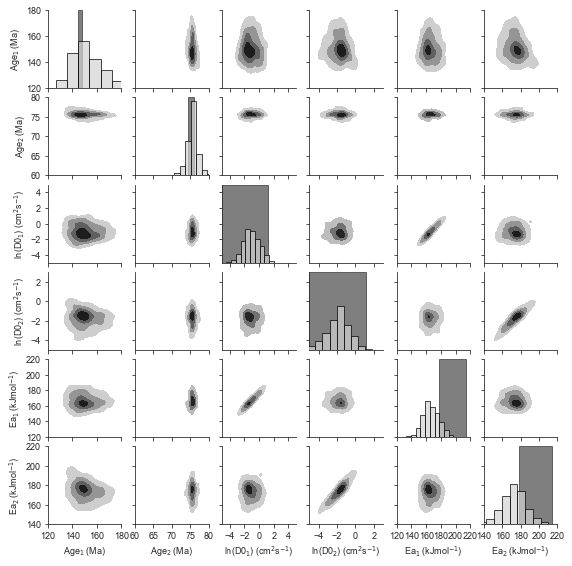

In [35]:
sns.set_style('ticks')
font = {"family": 'Arial', 
       "weight": "normal",
       'size': 9}

plt.rc("font", **font)

g = sns.PairGrid(df_dataframe[::3]); 
g = g.map_diag(plt.hist, facecolor = 'lightgrey', 
              edgecolor = 'k', 
              alpha = 0.7)
g.fig.set_size_inches(7.5, 7.5)
g.map_offdiag(sns.kdeplot,  
             cmap = 'Greys', 
              shade = True, 
              shade_lowest = False, 
              n_levels = 4)

# Y-labels 

g.axes[0,0].set_ylabel('Age$_1$ (Ma)')
g.axes[1,0].set_ylabel('Age$_2$ (Ma)')
g.axes[2,0].set_ylabel('ln(D0$_1$) (cm$^{2}$s$^{-1}$)')
g.axes[3,0].set_ylabel('ln(D0$_2$) (cm$^{2}$s$^{-1}$)')
g.axes[4,0].set_ylabel('Ea$_1$ (kJmol$^{-1}$)')
g.axes[5,0].set_ylabel('Ea$_2$ (kJmol$^{-1}$)')


# X-labels

g.axes[5,0].set_xlabel('Age$_1$ (Ma)')
g.axes[5,1].set_xlabel('Age$_2$ (Ma)')
g.axes[5,2].set_xlabel('ln(D0$_1$) (cm$^{2}$s$^{-1}$)')
g.axes[5,3].set_xlabel('ln(D0$_2$) (cm$^{2}$s$^{-1}$)')
g.axes[5,4].set_xlabel('Ea$_1$ (kJmol$^{-1}$)')
g.axes[5,5].set_xlabel('Ea$_2$ (kJmol$^{-1}$)')

# Set Axis Labels

g.axes[5,0].set_xlim(120, 180)
g.axes[5,0].locator_params(axis = 'x', nbins = 5)
g.axes[0,0].set_ylim(120, 180)
g.axes[0,0].locator_params(axis = 'y', nbins = 5)


g.axes[5,1].set_xlim(60, 80)
g.axes[5,1].locator_params(axis = 'x', nbins = 5)
g.axes[1,0].set_ylim(60, 80)
g.axes[1,0].locator_params(axis = 'y', nbins = 5)


g.axes[5,2].set_xlim(-5, 5)
g.axes[5,2].locator_params(axis = 'x', nbins = 5)
g.axes[2,0].set_ylim(-5, 5)
g.axes[2,0].locator_params(axis = 'y', nbins = 5)



g.axes[5,3].set_xlim(-5,3)
g.axes[5,3].locator_params(axis = 'x', nbins = 5)
g.axes[3,0].set_ylim(-5,3)
g.axes[3,0].locator_params(axis = 'y', nbins = 5)



g.axes[5,4].set_xlim(120, 220)
g.axes[5,4].locator_params(axis = 'x', nbins = 5)
g.axes[4,0].set_ylim(120, 220)
g.axes[4,0].locator_params(axis = 'y', nbins = 5)


g.axes[5,5].set_xlim(140, 220)
g.axes[5,5].locator_params(axis = 'x', nbins = 4)
g.axes[5,0].set_ylim(140, 220)
g.axes[5,0].locator_params(axis = 'y', nbins = 4)

# Add Priors

g.axes[0,0].axvspan(144.49, 147.77, color = 'k', 
                   alpha = 0.5, ymax = 1)

g.axes[1,1].axvspan(74.51, 76.11, color = 'k', 
                   alpha = 0.5, ymax = 1)

g.axes[2,2].axvspan(-6.4, 1.2, color = 'k', 
                   alpha = 0.5, ymax = 1)


g.axes[3,3].axvspan(-6.4, 1.2, color = 'k', 
                   alpha = 0.5, ymax = 1)

g.axes[4,4].axvspan(178, 214, color = 'k', 
                   alpha = 0.5, ymax = 1)

g.axes[5,5].axvspan(178, 214, color = 'k', 
                   alpha = 0.5, ymax = 1)

plt.savefig('kula3_bio_pg.pdf')

## Posterior DataFrame

In [32]:
df = pd.DataFrame({"age_model": x2,
                   "age_model_low":low_age, 
                   "age_model_high":high_age, 
                   "frel_model": x1, 
                   "frel_model_low": low_f, 
                   "frel_model_high":high_f, 
                   "age_data": data, 
                   "age_err": err,
                   "frel_data":x/100, 
                   "temp":temp1
                  })

In [33]:
df.to_csv("Kula_biotite_3_posterior.csv")

In [34]:
df2 = pm.trace_to_dataframe(trace[-SAMPLES::5])
df2.to_csv("Kula_biotite_3_trace.csv")

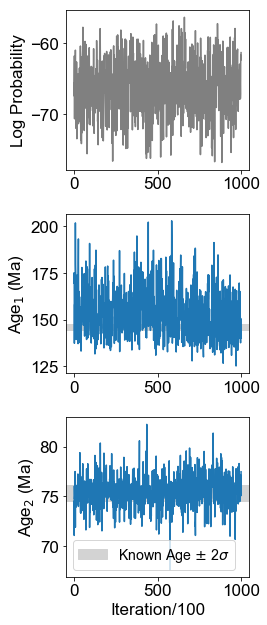

In [240]:
logp_model = Q.logp
logp = [logp_model(i) for i in trace[-SAMPLES::200]]
trace_plot = trace[-SAMPLES::400]

fig, ax = plt.subplots(3,1, figsize = (4,9))

ax[0].plot(logp, color = 'grey')
ax[0].set_ylabel('Log Probability')

ax[1].plot(trace_plot['age1'])
ax[1].set_ylabel('Age$_{1}$ (Ma)')
ax[1].axhspan(144.49, 147.77, color = 'lightgrey', 
             label = 'Known Age $\pm$ 2$\sigma$')

ax[2].plot(trace_plot['age2'])
ax[2].set_ylabel('Age$_{2}$ (Ma)')
ax[2].axhspan(74.51, 76.11,  color = 'lightgrey', 
             label = 'Known Age $\pm$ 2$\sigma$')


plt.legend(fontsize= 'small')

ax[2].set_xlabel('Iteration/100')
plt.tight_layout()
plt.savefig('kula3_logp.jpeg')

In [243]:
df = pd.DataFrame({"age_model": x2,
                   "age_model_low":low_age, 
                   "age_model_high":high_age, 
                  "frel_model": x1, 
                   "frel_model_low": low_f, 
                   "frel_model_high":high_f, 
                   "age_data": data, 
                   "age_err": err,
                   "frel_data":x/100, 
                   "temp":temp1
                  })

In [244]:
df.to_csv("Kula_biotite_3_posterior.csv")